In [1]:
import sys, glob, io, os
import numpy as np
from PIL import ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from get_data.font2img import draw_single_char, draw_example
from get_data.package import pickle_examples
from common.utils import centering_image, denorm_image
from common.dataset import TrainDataProvider, save_fixed_sample
from common.function import init_embedding

## 손글씨 역할을 할 폰트 데이터셋 생성

- 모델은 25개의 폰트로 pre-training을 진행했다. 


- 이제 Encoder는 고정한 채로 처음보는 폰트를 적은 데이터셋으로 학습할 차례! 


- Transfer Learning 기법 이용

In [2]:
SRC_PATH = './get_data/fonts/source/'
TRG_PATH = './get_data/fonts/handwriting_fonts/'
OUTPUT_PATH = './dataset-11172/'

src_font = glob.glob(os.path.join(SRC_PATH, '*.ttf'))[0]
print('source font:', src_font)

trg_fonts = glob.glob(os.path.join(TRG_PATH, '*.ttf'))
trg_fonts.sort()
print('target fonts:', len(trg_fonts), '개')

source font: ./get_data/fonts/source/source_font.ttf
target fonts: 3 개


In [3]:
trg_fonts

['./get_data/fonts/handwriting_fonts/50.ttf',
 './get_data/fonts/handwriting_fonts/51.ttf',
 './get_data/fonts/handwriting_fonts/52.ttf']

- 이전에 존재하는 총 46개의 폰트 중, 25개의 폰트로 사전학습을 했다.


- 이제 이 폰트들을 제외하고 한 번도 보지 않은 폰트로 Fine Tuning을 해볼 것


- 폰트는 최대한 손글씨에 가까운 것으로 먼저 test해본다.

#### Character 종류 - 2350자

In [4]:
file_path = './get_data/2350-common-hangul.txt'
with open(file_path) as f:
    charset = f.read().split('\n')
charset = charset[:-1]
print(len(charset))
charset[:10]

2350


['가', '각', '간', '갇', '갈', '갉', '갊', '감', '갑', '값']

- 데이터 생성 TEST - 두 글자 (target font, source font) 이미지 생성

### `50.ttf` 글씨체 먼저 데이터셋 만들어보기

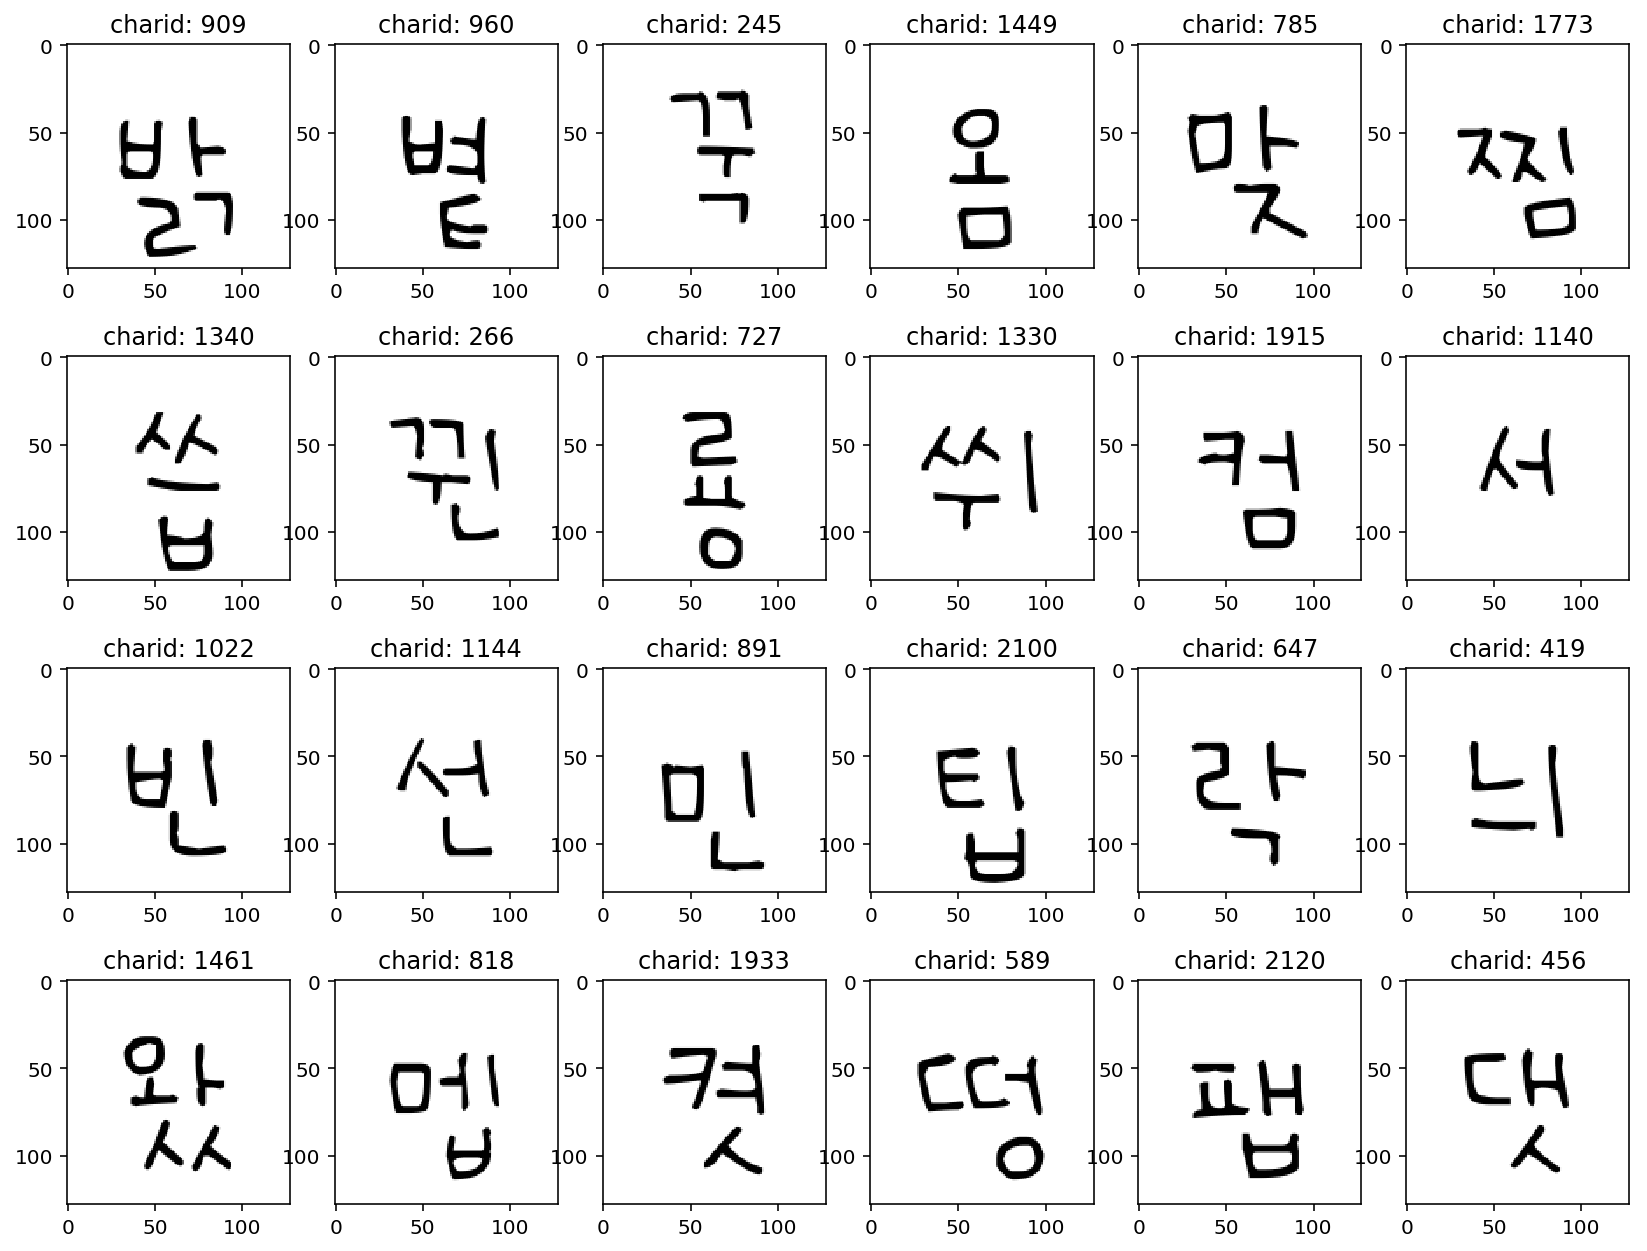

In [5]:
canvas_size = 128
plt.figure(figsize=(14, 11))
for i in range(24):
    font = ImageFont.truetype(trg_fonts[0], size=120)
    plt.subplot(4, 6, i+1)
    charid = np.random.choice(range(2350))
    dst_img = draw_single_char(charset[charid], font, canvas_size)
    plt.title('charid: %d' % charid)
    plt.imshow(dst_img, cmap='gray')
plt.show()

- Centering 만 진행해주기

In [6]:
count = 0
font_label = 0
canvas_size = 128
font_count = 0
src_char_size = 90
trg_char_size = 105
OUTPUT_PATH = './handwritings/handwriting_pngs_50/'
src_font = ImageFont.truetype(src_font, size=src_char_size)

font = trg_fonts[0]
font = ImageFont.truetype(font, size=trg_char_size)
character_count = 0
for c in charset:
    e = draw_example(c, src_font, font, canvas_size)
    if e:
        e.save(os.path.join(OUTPUT_PATH, "%d_%04d.png" % (font_label, character_count)))
        character_count += 1
        count += 1
        if count % 1000 == 0:
            print("processed %d chars" % count)
font_label += 1
print("processed %d chars, end" % count)

processed 1000 chars
processed 2000 chars
processed 2350 chars, end


- 50번 폰트만 먼저 생성

### `package.py`로 obj 파일 생성

In [4]:
from_dir = './handwritings/50font_handwriting_pngs/'
save_dir = './handwritings/50font_dataset_all/'
train_path = os.path.join(save_dir, "train.obj")
val_path = os.path.join(save_dir, "val.obj")

pickle_examples(from_dir, train_path=train_path, val_path=val_path, \
                train_val_split=0, with_charid=True)

all data num: 2350
0 imgs saved in val.obj, end
2350 imgs saved in train.obj, end


- train에 223자만 들어갔다 !
- 이 숫자만큼의 글자로만 학습 할 예정

## Fixed Samples

In [4]:
sample_size = 24
img_size = 128
fontid = 0
data_dir = './handwritings/50font_dataset_all/'
save_dir = './handwritings/fixed_sample/'

save_fixed_sample(sample_size, img_size, fontid, data_dir, save_dir)

unpickled total 2350 examples
train examples -> 2350


In [6]:
fixed_source = torch.load(os.path.join(save_dir, 'fixed_source_0.pkl'))
fixed_target = torch.load(os.path.join(save_dir, 'fixed_target_0.pkl'))
fixed_label = torch.load(os.path.join(save_dir, 'fixed_label_0.pkl'))

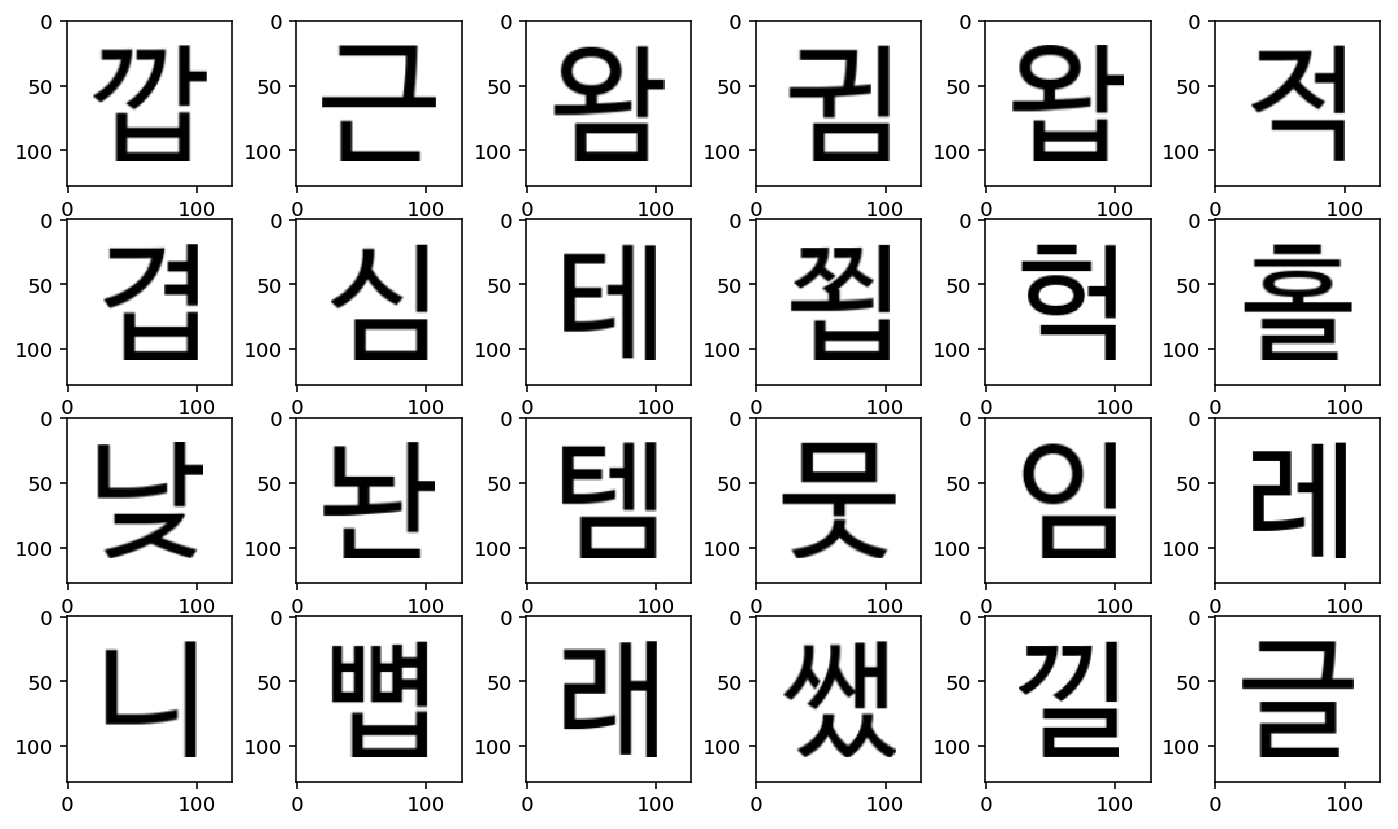

In [7]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_source):
    plt.subplot(4, 6, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

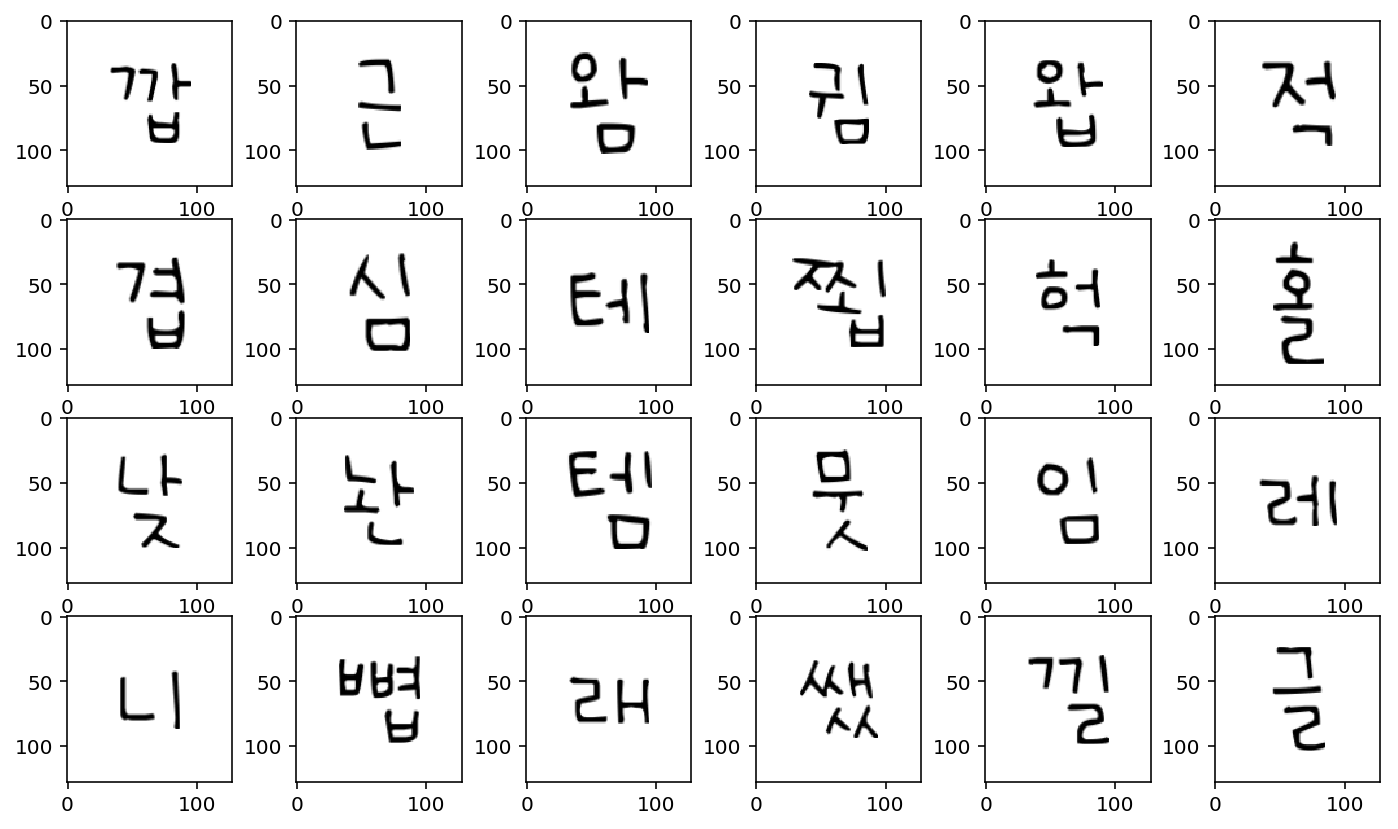

In [8]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target):
    plt.subplot(4, 6, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

#### Fake Target만 저장

In [9]:
save_path = './handwritings/fixed_sample/'
save_image(denorm_image(fixed_target.data), \
           os.path.join(save_path, '0_Ground_truth_target.png'), \
           nrow=6, pad_value=255)